# **Inversión de datos Electromagnéticos en el Dominio del Tiempo**

Autores

- **Paul Goyes**: [goyes.yesid@gmail.com](mailto:goyes.yesid@gmail.com)  
- **Daniela Quintero**: [yejoandajudi200305@gmail.com](mailto:yejoandajudi200305@gmail.com)  
- **Erick Villamizar**: [erickvillamizar25@gmail.com](mailto:erickvillamizar25@gmail.com)

En este notebook se extraen y leen los datos electromagnéticos adquiridos con el equipo ABEM WalkTEM 2, los cuales están contenidos en un archivo ufs. Además se realiza la inversión de los datos con la librería SimPEG.

## Importar las librerías necesarias

In [ ]:
# SimPEG
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model

from simpeg.utils import plot_1d_layer_model, download, mkvc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# Pygimli
from pygimli.physics import em

from discretize import TensorMesh
import os
import numpy as np
from scipy.constants import mu_0
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({"font.size": 14})

write_output = False

## Importar datos del equipo ABEMWALKTEM

Extraer y leer los datos electromagnéticos del archivo usf

In [ ]:
datas = em.readusffile('/content/20240901_110436_937_Station1.usf')


NSWEEPS = len(datas)
COILSIZE1=35 #0.5×0.5 en el RC-5
COILSIZE2=1400 # 10×10 en la RC-200

dbdts1, dbdts2, dbdts4, dbdts5= [], [], [], []
tiempo_1, tiempo_2, tiempo_4, tiempo_5= [], [], [], []

for sweep in datas:
    if sweep['CURRENT'] != 0:
        channel = int(sweep['CHANNEL'])
        voltage = sweep['VOLTAGE']
        current = sweep['CURRENT']
        time = sweep['TIME']
        coil_size = sweep['COIL_SIZE']

        if channel == 1:
            dbdts1.append(voltage)
            tiempo_1.append(time)
        elif channel == 2:
            dbdts2.append(voltage)
            tiempo_2.append(time)
        elif channel == 4:
            dbdts4.append(voltage)
            tiempo_4.append(time)
        elif channel == 5:
            dbdts5.append(voltage)
            tiempo_5.append(time)

Convertir las mediciones a arrays y obtener el promedio

In [ ]:
# RC-5 LM
dbdt_1 = np.array(dbdts1)
dbdt_RC5_Low= np.nanmean(dbdt_1,axis=0)

# RC-5 HM
dbdt_2 = np.array(dbdts2)
dbdt_RC5_High= np.nanmean(dbdt_2,axis=0)

# RC-200 LM
dbdt_4 = np.array(dbdts4)
dbdt_RC200_Low= np.nanmean(dbdt_4,axis=0)

# RC-200 HM
dbdt_5 = np.array(dbdts5)
dbdt_RC200_High= np.nanmean(dbdt_5,axis=0)

# Calcular el promedio de las LM
dbdt_low = np.mean([dbdt_RC5_Low, dbdt_RC200_Low], axis=0)

# Calcular el promedio de las HM
dbdt_high = np.mean([dbdt_RC5_High, dbdt_RC200_High], axis=0)

# Tiempo LM
tiempo_LM = np.array(tiempo_1)
tiempo_LM= np.nanmean(tiempo_LM,axis=0)

# Tiempo HM
tiempo_HM = np.array(tiempo_2)
tiempo_HM= np.nanmean(tiempo_HM,axis=0)

Graficar las mediciones LM y HM

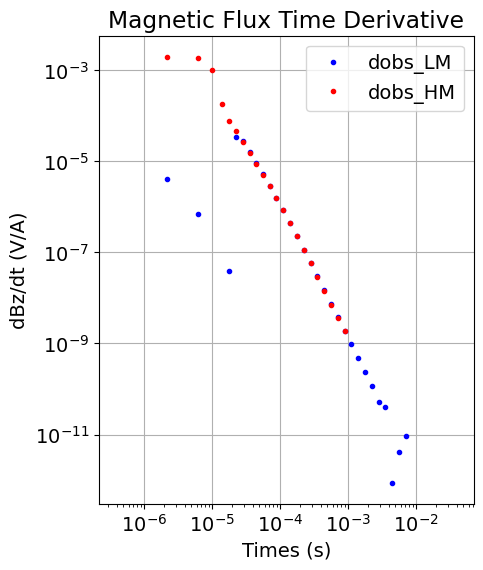

In [ ]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(tiempo_LM, dbdt_low, "b.",  label='dobs_LM')
ax.loglog(tiempo_HM, dbdt_high, "r.", label='dobs_HM')

ax.set_xlim([tiempo_LM.min()/10, 10*tiempo_LM.max()])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

Filtrar los datos (eliminar los que presenten dispersión)

In [ ]:
#Ajustar los dobs
dobs_LM = np.array([ 3.38525472e-05, 2.76701437e-05, 1.57618070e-05,
                     9.17713027e-06, 5.20997792e-06, 2.82605358e-06, 1.57008920e-06,
                     8.30184820e-07, 4.36890438e-07, 2.24103082e-07, 1.14162041e-07,
                     5.83687640e-08, 2.94639193e-08, 1.48223855e-08, 7.45800835e-09,
                     3.71896198e-09, 1.87989941e-09, 9.80784310e-10, 4.76401069e-10,])
time_LM = np.array([
                      2.26900e-05, 2.86900e-05, 3.61900e-05, 4.51900e-05, 5.66900e-05,
                      7.11900e-05, 8.96900e-05, 1.13190e-04, 1.42190e-04, 1.79190e-04,
                      2.25690e-04, 2.83690e-04, 3.57190e-04, 4.49690e-04, 5.66190e-04,
                      7.12690e-04, 8.97190e-04, 1.12969e-03, 1.42219e-03])
dobs_LM.shape

(19,)

In [ ]:
#Ajustar los dobs
dobs_HM = np.array([1.77050340e-04,
       7.56142867e-05, 4.49946855e-05, 2.59797362e-05, 1.49537570e-05,
       8.78385150e-06, 5.06012342e-06, 2.83882427e-06, 1.55434830e-06,
       8.27476090e-07, 4.32589608e-07, 2.23816416e-07, 1.12822144e-07,
       5.76702007e-08, 2.84472485e-08, 1.39132085e-08, 6.88137348e-09,
       3.63763404e-09, 1.87753891e-09])
time_HM = np.array([1.4190e-05, 1.8190e-05,
       2.2690e-05, 2.8690e-05, 3.6190e-05, 4.5190e-05, 5.6690e-05,
       7.1190e-05, 8.9690e-05, 1.1319e-04, 1.4219e-04, 1.7919e-04,
       2.2569e-04, 2.8369e-04, 3.5719e-04, 4.4969e-04, 5.6619e-04,
       7.1269e-04, 8.9719e-04])
dobs_HM.shape

(19,)

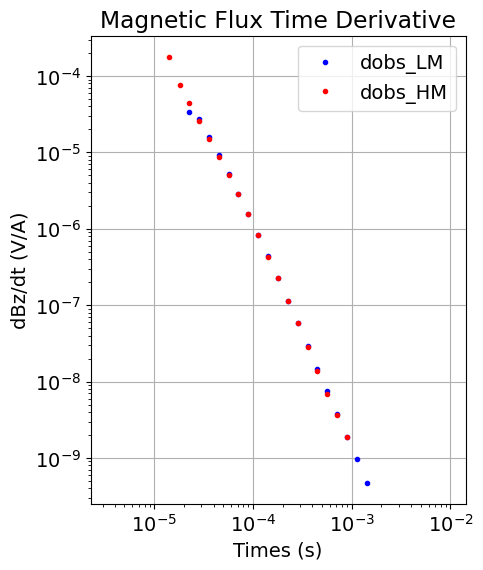

In [ ]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([time_LM.min()/10, 10*time_LM.max()])
#ax.set_ylim([1e-12, 1e-3])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

Interpolar las mediciones LM y HM para realizar la inversión

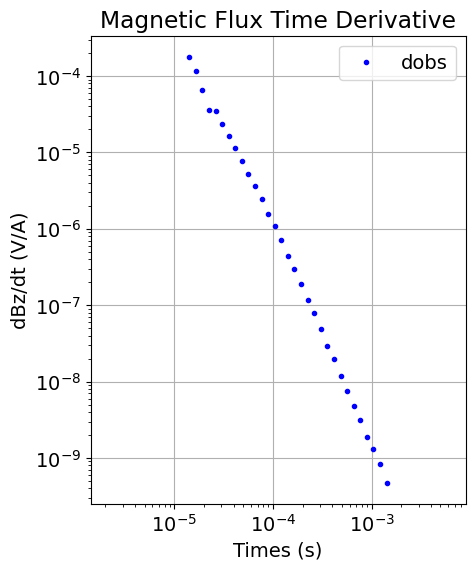

In [ ]:
from scipy import interpolate
x = np.concatenate((time_LM, time_HM))
y = np.concatenate((dobs_LM, dobs_HM))
f = interpolate.interp1d(x, y)

tiempo = np.logspace(np.log10(np.min(time_HM)),np.log10(np.max(time_LM)),31)
dobs = f(tiempo)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(tiempo, dobs, "b.", lw=3, label='dobs')
ax.set_xlim([time_HM.min()/10, 10*time_HM.max()])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

## Crear el forward modelling del TDEM

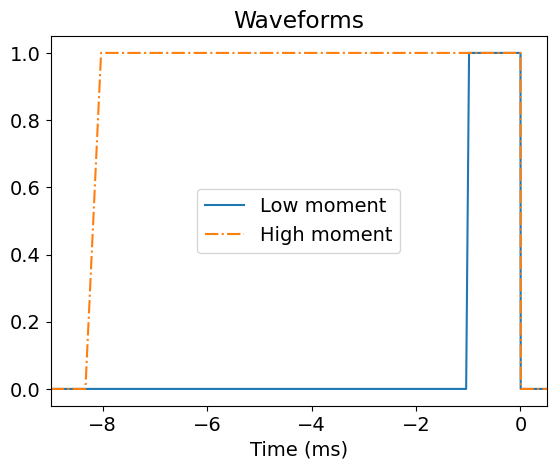

In [ ]:
  # Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Time (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

In [ ]:
# Fuente
source_location = np.array([0.0, 0.0, 1.0])
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # peak current amplitude
source_radius = 23.0  # loop radius

# Receptor
receiver_location = np.array([0.0, 0.0, 1.0])
receiver_orientation = "z"  # "x", "y" or "z"
times = tiempo.copy()  # time channels (s)

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)


source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_LM,
        current=source_current,
        radius=source_radius,
    )
]
# Arreglo
survey = tdem.Survey(source_list)

Para el Forward modelling se utiliza el modelo de campo obtenido con el equipo para propósitos comparativos

In [ ]:
# Conductividades
true_conductivities = 1/np.r_[52,28, 120, 90, 100,100]

# Espesores
true_thicknesses = np.r_[19, 31, 111, 199, 131]

# Número de capas
n_layers = len(true_conductivities)

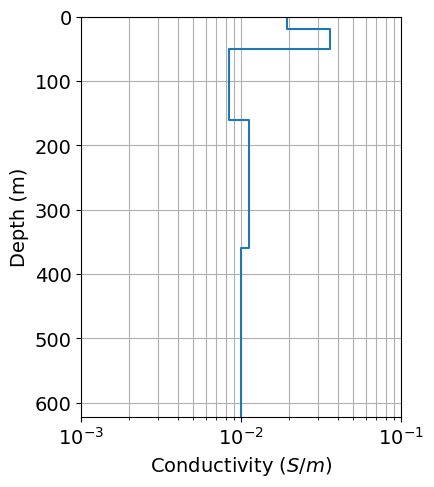

In [ ]:
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(true_thicknesses, true_conductivities, scale="log", ax=ax1)
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")
ax1.set_xlim([1e-3,1e-1])
plt.show()

In [ ]:
# Definir el modelo y mapeo para un modelo de conductividad
conductivity_model = true_conductivities.copy()
conductivity_map = maps.IdentityMap(nP=n_layers)

In [ ]:
simulation = tdem.simulation_1d.Simulation1DLayered(
    survey=survey,
    sigmaMap=conductivity_map,
    thicknesses=true_thicknesses,
)

In [ ]:
dpred_conductivity = simulation.dpred(conductivity_model)
dpred_conductivity.shape

(31,)

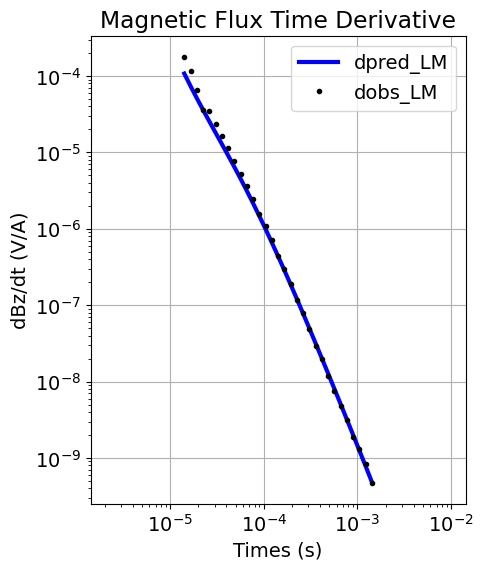

In [ ]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dpred_conductivity, "b-", lw=3, label='dpred_LM')

ax.loglog(tiempo, dobs, "k.",  label='dobs_LM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Times (s)")
ax.set_ylabel("dBz/dt (V/A)")
ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()


In [ ]:
estimated_conductivity = 0.01

# mínima distancia de difusión
d_min = 1250 * np.sqrt(tiempo.min() / estimated_conductivity)
print("Mínima distancia de difusión: {} m".format(d_min))

# máxima distancia de difusión
d_max = 1250 * np.sqrt(tiempo.max() / estimated_conductivity)
print("Máxima distancia de difusión: {} m".format(d_max))

MINIMUM DIFFUSION DISTANCE: 47.08702050459341 m
MAXIMUM DIFFUSION DISTANCE: 471.39918063144745 m


In [ ]:
dobs.shape

(31,)

In [ ]:
#Asignar incertidumbres y definir datos
uncertainties = 0.002 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=-dobs, standard_deviation=uncertainties)

## Definir el modelo inicial

In [ ]:
#Definir la malla

# Definir los espesores de las capas
layer_thicknesses = np.logspace(0, 1.93,10)

# Definir las celdas activas
h = np.r_[layer_thicknesses, layer_thicknesses[-1]]
h = np.flipud(h)

# Crear la regularización
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)

n_layers = len(layer_thicknesses) + 1  # Numero de capas


  TensorMesh: 11 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     11       -301.97         -0.00      1.00     85.11    1.64




## Inersión de los datos

In [ ]:
# Definir un modelo inicial. Resistividad (Ohm metro) o conductividad (S/m) para cada capa
starting_model = np.log(100 * np.ones(n_layers))

# Definir la correspondencia entre el modelo y las celdas activas
model_map = maps.ExpMap(nP=n_layers)

reference_resistivity_model = starting_model.copy()

In [ ]:
# Definir la física
simulation = tdem.Simulation1DLayered(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [ ]:
# Definir el desajuste de los datos
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Definir la regularización
reg = regularization.WeightedLeastSquares(
    regularization_mesh, reference_model=starting_model, alpha_s=1.0, alpha_x=1.0
)

#Definir la optimización
opt = optimization.InexactGaussNewton(maxIter=100,  maxIterLS=20, maxIterCG=20, tolCG=1e-3)

#Definir el problema inverso
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [ ]:
# Definir las directivas de inversión
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=5)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list = [update_jacobi, starting_beta, beta_schedule, target_misfit]

In [ ]:
# Combinar el problema inverso y las directivas
inv = inversion.BaseInversion(inv_prob, directives_list)

# Ejecutar la inversión
recovered_model = inv.run(starting_model)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.45e+04  3.74e+06  0.00e+00  3.74e+06    1.67e+06      0              
   1  1.45e+04  1.48e+06  1.20e+01  1.66e+06    1.17e+06      1              
   2  1.45e+04  8.31e+05  4.22e+01  1.44e+06    3.37e+06      0              
   3  7.23e+03  3.29e+05  4.29e+01  6.39e+05    7.16e+05      0              
   4  7.23e+03  1.85e+05  5.21e+01  5.61e+05    1.28e+06      0   Skip BFGS  
   5  7.23e+03  1.30e+05  4.87e+01  4.83e+05    3.43e+05      0   Skip B

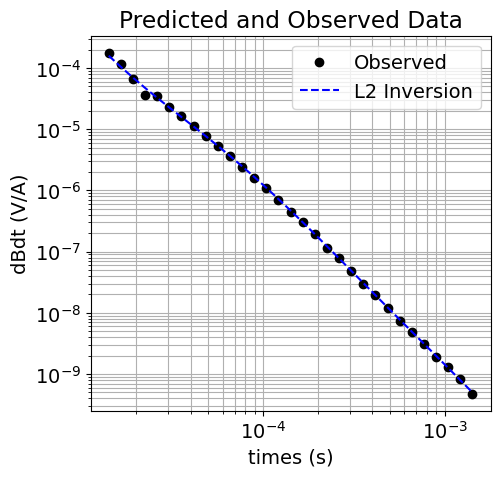

In [ ]:
dpred_L2 = simulation.dpred(recovered_model)

fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax1.loglog(tiempo, dobs, "ko")
ax1.loglog(times, -dpred_L2, "b--")
ax1.grid(which="both")
ax1.set_xlabel("times (s)")
ax1.set_ylabel("dBdt (V/A)")
ax1.set_title("Predicted and Observed Data")
ax1.legend(["Observed", "L2 Inversion"], loc="upper right")
plt.show()

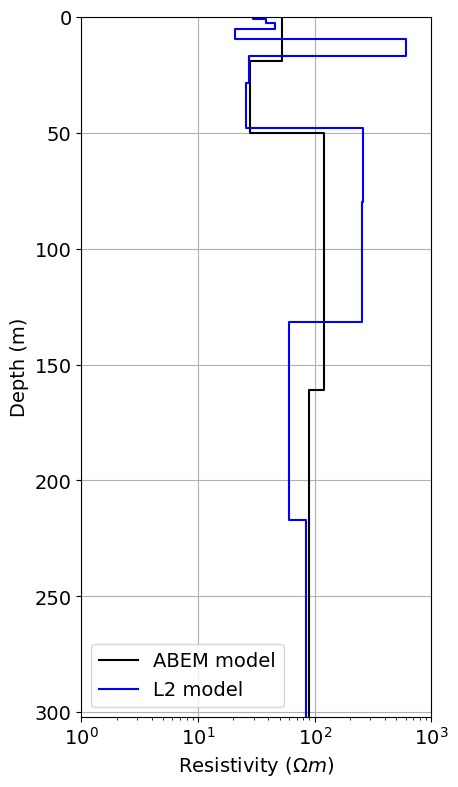

In [ ]:
# Graficar el modelo obtenido y compararlo con el modelo obtenido por el equipo
fig = plt.figure(figsize=(5, 10))

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thicknesses, 1/true_conductivities, ax=ax1, color="k", label="ABEM model")
plot_1d_layer_model(
    layer_thicknesses, model_map * recovered_model, ax=ax1, color="b", label="L2 model"
)
ax1.grid()
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = 1/true_conductivities.min(), 1/true_conductivities.max()
ax1.set_xlim(1e0, 1e3)
#ax1.set_ylim([300, 0])
#ax1.set_ylim([1.5*np.sum(true_thicknesses), 0])

ax1.legend()
plt.show()

In [ ]:
# calcular la métrica de error rms

rms = np.sqrt(np.mean((dobs - inv_prob.dpred) ** 2))
rms

7.954201028542058e-05